# TP 1: Parcours des protons dans la matière

In [53]:
# On fait quelques import importants:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas

## Question 1

Selon l'article au lien suivant:

$$\href{https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4407514/}{https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4407514/}$$

Nous avons que l'énergie ($T$) va de 1 Mev jusqu'à 250 Mev.

Avec la relativité restreinte, nous avons que

$$T = (\gamma - 1) m_0 c^2$$

alors,

$$\implies \gamma = \frac{T}{m_0 c^2} + 1 $$

De plus, selon la relativité restreinte encore:

$$\gamma = \frac{1}{\sqrt{1 - \beta^2}}$$

## Question 2

Pour commencer, puisque nous cherchons une densité d'électron, celle-ci correspond donc au nombre d'électron par gramme multiplié par la densité volumique.

$$n_e = N_e\rho $$

Puisqu'il y a plusieurs atomes, avec des proportions différentes, nous devons donc considérer la masse molaire et 
le nombre d'avogadro ainsi que les proportions afin de déterminer le nombre d'électron par gramme

$$N_e = \sum_i\frac{ Z_i \xi_i N_0}{M_i}$$



In [59]:
N_0: float = 6.02214e23  # nomrbre d'avogadro
Z_to_molar_mass: dict = {
#   Z: molar mass [g]
    1: 1.0,
    6: 12.0,
    7: 14.0,
    8: 16.0,
    12: 24.3,
    15: 31.0,
    16: 32.1,
    20: 40.1,
    30: 65.4
}

def get_N_e(composition_dict: dict) -> int:
    N_e: float = 0
    for Z_i, xi_i in composition_dict.items():
        N_e += (Z_i*xi_i*N_0)/Z_to_molar_mass[Z_i]
    return int(N_e)

In [63]:
# composition icrp, [icrp : = cortical bone]
# source du NIST: https://physics.nist.gov/cgi-bin/Star/compos.pl?refer=ap&matno=120}{https://physics.nist.gov/cgi-bin/Star/compos.pl?refer=ap&matno=120

density_icrp: float = 1.85  # [g/cm^3]

composition_icrp: dict = {
#   Z: abondance relative
    1: 0.047234,
    6: 0.144330,
    7: 0.041990,
    12: 0.002200,
    15: 0.104970,
    16: 0.003150,
    20: 0.209930,
    30: 0.000100
}

N_e_icrp: int = get_N_e(composition_icrp)  # nombre d'électron par gramme de icrp
print(N_e_icrp)

179816019008477370253312


In [64]:
# composition icrp, 
# source du NIST: https://physics.nist.gov/cgi-bin/Star/compos.pl?refer=ap&matno=120}{https://physics.nist.gov/cgi-bin/Star/compos.pl?refer=ap&matno=120

density_water: float = 1.00  # [g/cm^3]

composition_water: dict = {
#   Z: abondance relative
    1: 0.111894,
    8: 0.888106
}

N_e_water: int = get_N_e(composition_water)  # nombre d'électron par gramme de icrp
print(N_e_water)

334799066657999978233856


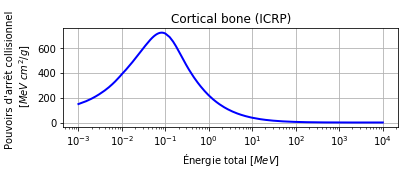

In [49]:
df_icrp = pandas.read_csv(f"{os.getcwd()}//Data/NIST_DATA_ICRP.txt", delimiter='|', header=2)
df_icrp = df_icrp.drop(columns=df_icrp.columns[-1])
data_icrp = df_icrp.to_numpy()


fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

line, = ax.plot(data_icrp[:, 0], data_icrp[:, 1], color='blue', lw=2)
ax.set_xscale('log')
ax.set_title("Cortical bone (ICRP)")
ax.set_xlabel("Énergie total [$MeV$]")
ax.set_ylabel("Pouvoirs d'arrêt collisionnel \n [$MeV \; cm^2/g$]")

plt.grid()
plt.show()

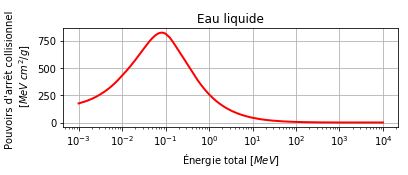

In [50]:
df_water = pandas.read_csv(f"{os.getcwd()}//Data/NIST_DATA_LIQUID_WATER.txt", delimiter='|', header=2)
df_water = df_water.drop(columns=df_water.columns[-1])
data_water = df_water.to_numpy()


fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

line, = ax.plot(data_water[:, 0], data_water[:, 1], color='red', lw=2)
ax.set_xscale('log')
ax.set_title("Eau liquide")
ax.set_xlabel("Énergie total [$MeV$]")
ax.set_ylabel("Pouvoirs d'arrêt collisionnel \n [$MeV \; cm^2/g$]")

plt.grid()
plt.show()